In [2]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

/Users/dormann/Documents/GitHub/src


In [3]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# AE: AE3, AE4 fused

In [104]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load AE4 data
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

AE = pd.concat([AE3, AE4], axis=1)
print(AE.shape)

#Fuse families info
y_AE4 += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE = np.hstack((y_AE3, y_AE4))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE,0.05)
AE = AE[gene_expressed]
print(AE.shape)

#Store the name of genes of interest
genes_interest = AE.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE_interest.csv', index=False)

#Create preprocess data 
AE.to_csv('../data/processed_data/AE.csv', index=False)
pd.DataFrame(y_AE).to_csv('../data/processed_data/y_AE.csv', index=False)

(32285, 333) (333,)
(32285, 1473) (1473,)
(32285, 1806)
(10470, 1806)


# Baseline with genes expressed at least in 5% of cells

In [105]:
#Load preprocess data
AE= np.array(pd.read_csv ('../data/processed_data/AE.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE.csv')))
print(np.shape(AE), np.shape(y))

(1806, 10470) (1806,)


In [23]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE,y)

In [24]:
print(AE.shape, len(pred))
acc = model.score_
print(acc, model.recovery)

(1806, 10470) 1806
0.10467179183914843 0.8809523809523809


# Mutual information maximizer (MIM)

test 0.3084351022683486 0.031083813677078125


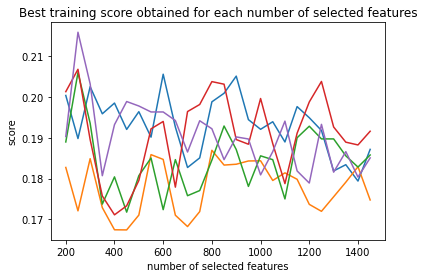

In [25]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [26]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_,model.recovery)

0.17310087173100872 0.8471760797342193


In [28]:
get_best_genes_names(subset, '../data/processed_data/AE_interest.csv', '../data/optimized_subsets/AEgenes_bestMIM.csv')

# Anova F test

test 0.28541536637864334 0.038710418560044


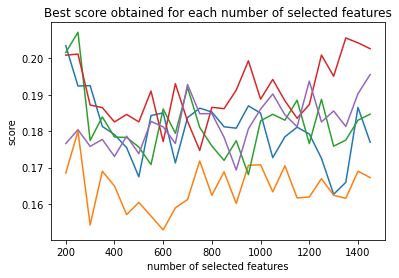

In [106]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [107]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_,model.recovery)

0.1789229878401853 0.8953488372093024


In [108]:
get_best_genes_names(subset, '../data/processed_data/AE_interest.csv', '../data/optimized_subsets/AEgenes_bestANOVA.csv')

# Predict on data sets separately

In [109]:
#Load AE3 data and optimized subset
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AEgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE3),compute_precision,True)
x_subset = np.array(AE3.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE3)

print(model.score_,model.recovery)

(32285, 333) (333,)
0.5161290322580645 0.8528528528528528


In [110]:
#Load AE4 data and optimized subset
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AEgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE4),compute_precision,True)
x_subset = np.array(AE4.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE4)

print(model.score_,model.recovery)

(32285, 1473) (1473,)
0.12221423436376708 0.8940936863543788


# AE3-MEF: AE3, MEF fused

In [111]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

AE3_MEF = pd.concat([AE3, D0,D6,D15], axis=1)
print(AE3_MEF.shape)

#Fuse families infos
y_D0 += max(y_AE3)
y_AE3_MEF = np.hstack((y_AE3, y_D0))

y_D6 += max(y_AE3_MEF)
y_AE3_MEF = np.hstack((y_AE3_MEF, y_D6))

y_D15 += max(y_AE3_MEF)
y_AE3_MEF = np.hstack((y_AE3_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE3_MEF,0.05)
AE3_MEF = AE3_MEF[gene_expressed]
print(AE3_MEF.shape)

#Store the name of genes of interest
genes_interest = AE3_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE3_MEF_interest.csv', index=False)

#Create preprocess data 
AE3_MEF.to_csv('../data/processed_data/AE3_MEF.csv', index=False)
pd.DataFrame(y_AE3_MEF).to_csv('../data/processed_data/y_AE3_MEF.csv', index=False)

(32285, 333) (333,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(32285, 1126)
(11485, 1126)


# Baseline with genes expressed at least in 5% of cells

In [112]:
#Load preprocess data
AE3_MEF = np.array(pd.read_csv ('../data/processed_data/AE3_MEF.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE3_MEF.csv')))
print(np.shape(AE3_MEF), np.shape(y))

(1126, 11485) (1126,)


In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE3_MEF,y)

print(model.score_, model.recovery)

0.6370967741935484 0.6607460035523979


# Mutual information maximizer (MIM)

test 0.9041150995356834 0.014267339344974426


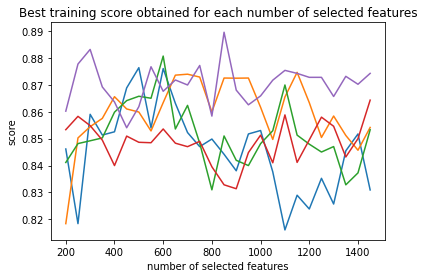

In [113]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3_MEF, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [114]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE3_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_,model.recovery)

0.8443396226415094 0.7531083481349912


In [115]:
get_best_genes_names(subset, '../data/processed_data/AE3_MEF_interest.csv', '../data/optimized_subsets/AE3_MEFgenes_bestMIM.csv')

# Anova F test

test 0.9251362148837605 0.026385023227582623


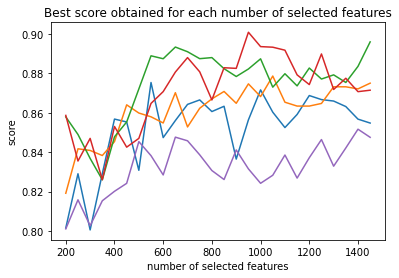

In [116]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3_MEF, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [117]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE3_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_,model.recovery)

0.8587962962962963 0.7673179396092362


In [118]:
get_best_genes_names(subset, '../data/processed_data/AE3_MEF_interest.csv', '../data/optimized_subsets/AE3_MEFgenes_bestANOVA.csv')

# Predict on data sets separately

In [119]:
#Load AE3 data and optimized subset
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE3_MEFgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE3),compute_precision,True)
x_subset = np.array(AE3.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE3)

print(model.score_,model.recovery)

(32285, 333) (333,)
0.5797872340425532 0.7417417417417418


In [120]:
#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE3_MEFgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D0),compute_precision,True)
x_subset = np.array(D0.loc[subset]).T
pred = model.fit_predict(x_subset,y_D0)

print(model.score_,model.recovery)

(32285, 461) (461,)
0.9162303664921466 0.8286334056399133


In [121]:
#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE3_MEFgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D6),compute_precision,True)
x_subset = np.array(D6.loc[subset]).T
pred = model.fit_predict(x_subset,y_D6)

print(model.score_,model.recovery)

(32285, 154) (154,)
0.8333333333333334 0.7792207792207793


In [122]:
#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE3_MEFgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D15),compute_precision,True)
x_subset = np.array(D15.loc[subset]).T
pred = model.fit_predict(x_subset,y_D15)

print(model.score_,model.recovery)

(32285, 178) (178,)
0.9873417721518988 0.8876404494382022


# AE4-MEF: AE4, MEF fused

In [3]:
#Load AE3 data
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

AE4_MEF = pd.concat([AE4, D0,D6,D15], axis=1)
print(AE4_MEF.shape)

#Fuse families infos
y_D0 += max(y_AE4)
y_AE4_MEF = np.hstack((y_AE4, y_D0))

y_D6 += max(y_AE4_MEF)
y_AE4_MEF = np.hstack((y_AE4_MEF, y_D6))

y_D15 += max(y_AE4_MEF)
y_AE4_MEF = np.hstack((y_AE4_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE4_MEF,0.05)
AE4_MEF = AE4_MEF[gene_expressed]
print(AE4_MEF.shape)

#Store the name of genes of interest
genes_interest = AE4_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE4_MEF_interest.csv', index=False)

#Create preprocess data 
AE4_MEF.to_csv('../data/processed_data/AE4_MEF.csv', index=False)
pd.DataFrame(y_AE4_MEF).to_csv('../data/processed_data/y_AE4_MEF.csv', index=False)

(32285, 1473) (1473,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(32285, 2266)
(10625, 2266)


# Baseline with genes expressed at least in 5% of cells

In [4]:
#Load preprocess data
AE4_MEF = np.array(pd.read_csv ('../data/processed_data/AE4_MEF.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE4_MEF.csv')))
print(np.shape(AE4_MEF), np.shape(y))

(2266, 10625) (2266,)


In [5]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE4_MEF,y)

print(model.score_, model.recovery)

0.18370073480293922 0.8592233009708737


# Mutual information maximizer (MIM)

test 0.3421161903039584 0.028330524625542416


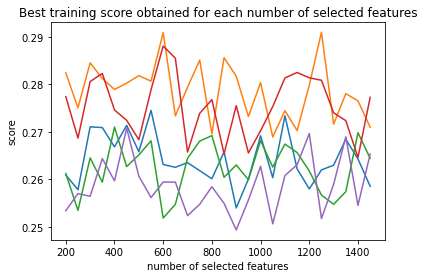

In [6]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE4_MEF, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [7]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE4_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.26941255908170153 0.9152691968225949


In [8]:
get_best_genes_names(subset, '../data/processed_data/AE4_MEF_interest.csv', '../data/optimized_subsets/AE4_MEFgenes_bestMIM.csv')

# Anova F test

test 0.30031492687857886 0.014567535882473916


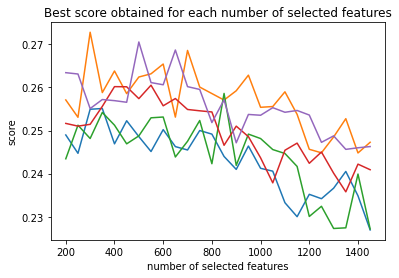

In [9]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE4_MEF, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [10]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE4_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.24347258485639686 0.9298323036187114


In [11]:
get_best_genes_names(subset, '../data/processed_data/AE4_MEF_interest.csv', '../data/optimized_subsets/AE4_MEFgenes_bestANOVA.csv')

# Predict on data sets separately

In [123]:
#Load AE4 data and optimized subset
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE4_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE4),compute_precision,True)
x_subset = np.array(AE4.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE4)

print(model.score_,model.recovery)

(32285, 1473) (1473,)
0.0577305905773059 0.9497623896809233


In [124]:
#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE4_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D0),compute_precision,True)
x_subset = np.array(D0.loc[subset]).T
pred = model.fit_predict(x_subset,y_D0)

print(model.score_,model.recovery)

(32285, 461) (461,)
0.9137055837563451 0.8546637744034707


In [125]:
#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE4_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D6),compute_precision,True)
x_subset = np.array(D6.loc[subset]).T
pred = model.fit_predict(x_subset,y_D6)

print(model.score_,model.recovery)

(32285, 154) (154,)
0.8166666666666667 0.7792207792207793


In [126]:
#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE4_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D15),compute_precision,True)
x_subset = np.array(D15.loc[subset]).T
pred = model.fit_predict(x_subset,y_D15)

print(model.score_,model.recovery)

(32285, 178) (178,)
0.9759036144578314 0.9325842696629213


# AE-MEF: AE3, AE4, MEF fused

In [12]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load AE4 data
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

AE_MEF = pd.concat([AE3, AE4, D0 ,D6, D15], axis=1)
print(AE_MEF.shape)

#Fuse families infos
y_AE4 += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_MEF = np.hstack((y_AE3, y_AE4))

y_D0 += max(y_AE_MEF)
y_AE_MEF = np.hstack((y_AE_MEF, y_D0))

y_D6 += max(y_AE_MEF)
y_AE_MEF = np.hstack((y_AE_MEF, y_D6))

y_D15 += max(y_AE_MEF)
y_AE_MEF = np.hstack((y_AE_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_MEF,0.05)
AE_MEF = AE_MEF[gene_expressed]
print(AE_MEF.shape)

#Store the name of genes of interest
genes_interest = AE_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE_MEF_interest.csv', index=False)

#Create preprocess data 
AE_MEF.to_csv('../data/processed_data/AE_MEF.csv', index=False)
pd.DataFrame(y_AE_MEF).to_csv('../data/processed_data/y_AE_MEF.csv', index=False)

(32285, 333) (333,)
(32285, 1473) (1473,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(32285, 2599)
(10955, 2599)


# Baseline with genes expressed at least in 5% of cells

In [13]:
#Load preprocess data
AE_MEF = np.array(pd.read_csv ('../data/processed_data/AE_MEF.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE_MEF.csv')))
print(np.shape(AE_MEF), np.shape(y))

(2599, 10955) (2599,)


In [14]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_MEF,y)

print(model.score_, model.recovery)

0.2085889570552147 0.8214697960754136


# Mutual information maximizer (MIM)

test 0.42760191301482264 0.03367973736042708


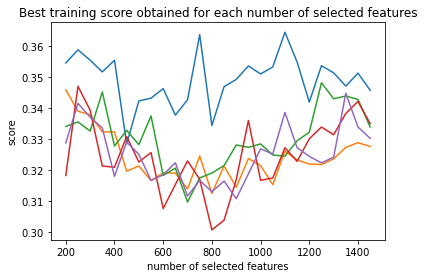

In [15]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_MEF, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [16]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.3337222870478413 0.9045786841092728


In [17]:
get_best_genes_names(subset, '../data/processed_data/AE_MEF_interest.csv', '../data/optimized_subsets/AE_MEFgenes_bestMIM.csv')

# Anova F test

test 0.3516812551550044 0.02070823104536013


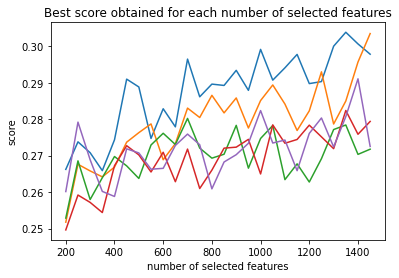

In [18]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_MEF, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [19]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_MEF[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.26686567164179104 0.8826471719892266


In [20]:
get_best_genes_names(subset, '../data/processed_data/AE_MEF_interest.csv', '../data/optimized_subsets/AE_MEFgenes_bestANOVA.csv')

# Predict on data sets separately

In [127]:
#Load AE3 data and optimized subset
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE3),compute_precision,True)
x_subset = np.array(AE3.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE3)

print(model.score_,model.recovery)

(32285, 333) (333,)
0.475 0.8648648648648649


In [128]:
#Load AE4 data and optimized subset
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE4),compute_precision,True)
x_subset = np.array(AE4.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE4)

print(model.score_,model.recovery)

(32285, 1473) (1473,)
0.11002785515320335 0.9341479972844535


In [129]:
#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D0),compute_precision,True)
x_subset = np.array(D0.loc[subset]).T
pred = model.fit_predict(x_subset,y_D0)

print(model.score_,model.recovery)

(32285, 461) (461,)
0.9086294416243654 0.8546637744034707


In [130]:
#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D6),compute_precision,True)
x_subset = np.array(D6.loc[subset]).T
pred = model.fit_predict(x_subset,y_D6)

print(model.score_,model.recovery)

(32285, 154) (154,)
0.7666666666666667 0.7792207792207793


In [131]:
#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE_MEFgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D15),compute_precision,True)
x_subset = np.array(D15.loc[subset]).T
pred = model.fit_predict(x_subset,y_D15)

print(model.score_,model.recovery)

(32285, 178) (178,)
0.9886363636363636 0.9887640449438202


# AE3-LK: AE3, LK fused

In [46]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Drop genes not present in AE3
LK = LK.loc[AE3.index.intersection(LK.index)]
AE3 = AE3.loc[LK.index]
print(np.shape(AE3), np.shape(y_AE3))

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
AE3 = AE3.drop(index= non_unique_genes)
LK = LK.drop(non_unique_genes)

AE_LK = pd.concat([AE3, LK], axis=1)
print(AE_LK.shape)

#Fuse families infos
y_LK += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_LK = np.hstack((y_AE3, y_LK))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_LK,0.05)
AE_LK = AE_LK[gene_expressed]
print(AE_LK.shape)

#Store the name of genes of interest
genes_interest = AE_LK.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE3_LK_interest.csv', index=False)

#Create preprocess data 
AE_LK.to_csv('../data/processed_data/AE3_LK.csv', index=False)
pd.DataFrame(y_AE_LK).to_csv('../data/processed_data/y_AE3_LK.csv', index=False)

(32285, 333) (333,)
(16760, 610) (610,)
(16410, 333) (333,)
(16182, 943)
(10246, 943)


# Baseline with genes expressed at least in 5% of cells

In [55]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/AE3_LK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE3_LK.csv')))
print(np.shape(AE_LK), np.shape(y))

(943, 10246) (943,)


In [56]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

0.2618629173989455 0.7550371155885471


# Mutual information maximizer (MIM)

test 0.4169767452526073 0.06564367395602635


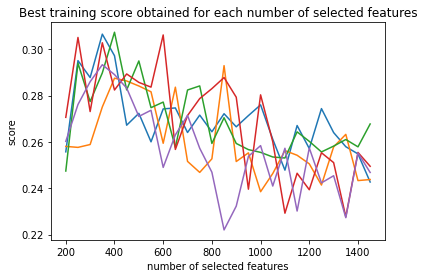

In [57]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [58]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.2987910189982729 0.8080593849416755


In [59]:
get_best_genes_names(subset, '../data/processed_data/AE3_LK_interest.csv', '../data/optimized_subsets/AE3_LKgenes_bestMIM.csv')

# Anova F test

test 0.40067618348161566 0.06288237125780397


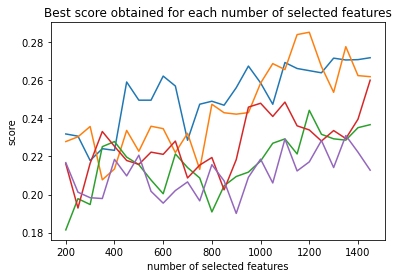

In [60]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [61]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.23156089193825044 0.7974549310710498


In [62]:
get_best_genes_names(subset, '../data/processed_data/AE3_LK_interest.csv', '../data/optimized_subsets/AE3_LKgenes_bestANOVA.csv')

# Predict on data sets separately

In [132]:
#Load AE3 data and optimized subset
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE3_LKgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE3),compute_precision,True)
x_subset = np.array(AE3.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE3)

print(model.score_,model.recovery)

(32285, 333) (333,)
0.5475113122171946 0.8588588588588588


In [133]:
#Load Weinreb LK data and optimized subset
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE3_LKgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_LK),compute_precision,True)
x_subset = np.array(LK.loc[subset]).T
pred = model.fit_predict(x_subset,y_LK)

print(model.score_,model.recovery)

(20071, 2020) (2020,)
0.03206997084548105 0.6792079207920793


# AE4-LK: AE4, LK fused

In [50]:
#Load AE3 data
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Drop genes not present in AE3
LK = LK.loc[AE4.index.intersection(LK.index)]
AE4 = AE4.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
AE4 = AE4.drop(index= non_unique_genes)
LK = LK.drop(non_unique_genes)

AE_LK = pd.concat([AE4, LK], axis=1)
print(AE_LK.shape)

#Fuse families infos
y_LK += max(y_AE4) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_LK = np.hstack((y_AE4, y_LK))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_LK,0.05)
AE_LK = AE_LK[gene_expressed]
print(AE_LK.shape)

#Store the name of genes of interest
genes_interest = AE_LK.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE4_LK_interest.csv', index=False)

#Create preprocess data 
AE_LK.to_csv('../data/processed_data/AE4_LK.csv', index=False)
pd.DataFrame(y_AE_LK).to_csv('../data/processed_data/y_AE4_LK.csv', index=False)

(32285, 1473) (1473,)
(16760, 610) (610,)
(16182, 2083)
(9359, 2083)


# Baseline with genes expressed at least in 5% of cells

In [63]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/AE4_LK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE4_LK.csv')))
print(np.shape(AE_LK), np.shape(y))

(2083, 9359) (2083,)


In [64]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

0.07763221737020863 0.9011041766682669


# Mutual information maximizer (MIM)

test 0.2220548175069715 0.033723737236391944


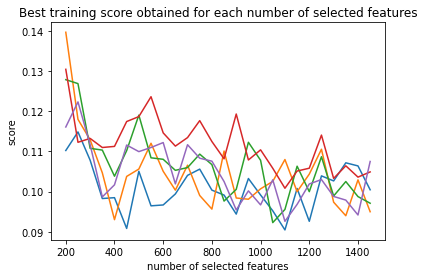

In [65]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [66]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.10584123814278582 0.8929428708593375


In [67]:
get_best_genes_names(subset, '../data/processed_data/AE4_LK_interest.csv', '../data/optimized_subsets/AE4_LKgenes_bestMIM.csv')

# Anova F test

test 0.24257950720218785 0.0348167356611861


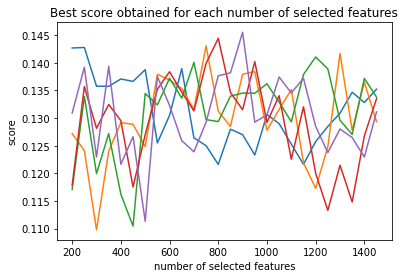

In [68]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [69]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.12782805429864252 0.8122899663946231


In [70]:
get_best_genes_names(subset, '../data/processed_data/AE4_LK_interest.csv', '../data/optimized_subsets/AE4_LKgenes_bestANOVA.csv')

# Predict on data sets separately

In [134]:
#Load AE4 data and optimized subset
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE4_LKgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE4),compute_precision,True)
x_subset = np.array(AE4.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE4)

print(model.score_,model.recovery)

(32285, 1473) (1473,)
0.12271186440677966 0.9185336048879837


In [135]:
#Load Weinreb LK data and optimized subset
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE4_LKgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_LK),compute_precision,True)
x_subset = np.array(LK.loc[subset]).T
pred = model.fit_predict(x_subset,y_LK)

print(model.score_,model.recovery)

(20071, 2020) (2020,)
0.01859799713876967 0.692079207920792


# MEF-LK: MEF, LK fused

In [51]:
#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

MEF = pd.concat([D0 ,D6, D15], axis=1)

#Drop genes not present in AE3
LK = LK.loc[MEF.index.intersection(LK.index)]
MEF = MEF.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
MEF = MEF.drop(index= non_unique_genes)
LK = LK.drop(non_unique_genes)


LK_MEF = pd.concat([LK, MEF], axis=1)
print(LK_MEF.shape)

y_D0 += max(y_LK)
y_LK_MEF = np.hstack((y_LK, y_D0))

y_D6 += max(y_LK_MEF)
y_LK_MEF = np.hstack((y_LK_MEF, y_D6))

y_D15 += max(y_LK_MEF)
y_LK_MEF = np.hstack((y_LK_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(LK_MEF,0.05)
LK_MEF = LK_MEF[gene_expressed]
print(LK_MEF.shape)

#Store the name of genes of interest
genes_interest = LK_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/MEF_LK_interest.csv', index=False)

#Create preprocess data 
LK_MEF.to_csv('../data/processed_data/MEF_LK.csv', index=False)
pd.DataFrame(y_LK_MEF).to_csv('../data/processed_data/y_MEF_LK.csv', index=False)

(16760, 610) (610,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(16182, 1403)
(9686, 1403)


# Baseline with genes expressed at least in 5% of cells

In [71]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/MEF_LK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_MEF_LK.csv')))
print(np.shape(AE_LK), np.shape(y))

(1403, 9686) (1403,)


In [72]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

0.4959016393442623 0.6956521739130435


# Mutual information maximizer (MIM)

test 0.7399378572909571 0.06791559548001305


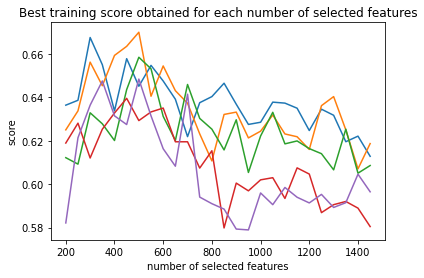

In [73]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [74]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.6264591439688716 0.7327156094084105


In [75]:
get_best_genes_names(subset, '../data/processed_data/MEF_LK_interest.csv', '../data/optimized_subsets/MEF_LKgenes_bestMIM.csv')

# Anova F test

test 0.7953559246849425 0.06419622567793774


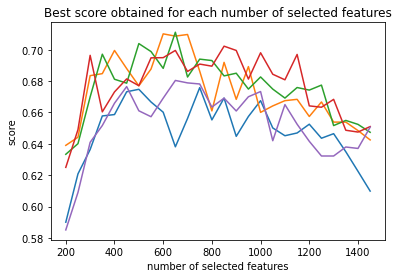

In [76]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [77]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.6621359223300971 0.7341411261582323


In [78]:
get_best_genes_names(subset, '../data/processed_data/MEF_LK_interest.csv', '../data/optimized_subsets/MEF_LKgenes_bestANOVA.csv')

# Predict on data sets separately

In [136]:
#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/MEF_LKgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D0),compute_precision,True)
x_subset = np.array(D0.loc[subset]).T
pred = model.fit_predict(x_subset,y_D0)

print(model.score_,model.recovery)

(32285, 461) (461,)
0.9072164948453608 0.841648590021692


In [137]:
#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/MEF_LKgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D6),compute_precision,True)
x_subset = np.array(D6.loc[subset]).T
pred = model.fit_predict(x_subset,y_D6)

print(model.score_,model.recovery)

(32285, 154) (154,)
0.8947368421052632 0.7402597402597403


In [138]:
#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/MEF_LKgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D15),compute_precision,True)
x_subset = np.array(D15.loc[subset]).T
pred = model.fit_predict(x_subset,y_D15)

print(model.score_,model.recovery)

(32285, 178) (178,)
0.9767441860465116 0.9662921348314607


In [139]:
#Load Weinreb LK data and optimized subset
LK = pd.read_csv ('../data/merged_data/LK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LK.csv')))
print(np.shape(LK), np.shape(y_LK))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/MEF_LKgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_LK),compute_precision,True)
x_subset = np.array(LK.loc[subset]).T
pred = model.fit_predict(x_subset,y_LK)

print(model.score_,model.recovery)

(20071, 2020) (2020,)
0.07469512195121951 0.6495049504950495


# AE3-LSK: AE3, LSK fused

In [52]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LSK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Drop genes not present in AE3
LK = LK.loc[AE3.index.intersection(LK.index)]
AE3 = AE3.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
AE3 = AE3.drop(index= AE3.index.intersection(non_unique_genes))
LK = LK.loc[AE3.index]

AE_LK = pd.concat([AE3, LK], axis=1)
print(AE_LK.shape)

#Fuse families infos
y_LK += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_LK = np.hstack((y_AE3, y_LK))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_LK,0.05)
AE_LK = AE_LK[gene_expressed]
print(AE_LK.shape)

#Store the name of genes of interest
genes_interest = AE_LK.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE3_LSK_interest.csv', index=False)

#Create preprocess data 
AE_LK.to_csv('../data/processed_data/AE3_LSK.csv', index=False)
pd.DataFrame(y_AE_LK).to_csv('../data/processed_data/y_AE3_LSK.csv', index=False)

(32285, 333) (333,)
(25289, 3383) (3383,)
(24176, 3716)
(8781, 3716)


# Baseline with genes expressed at least in 5% of cells

In [79]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/AE3_LSK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE3_LSK.csv')))
print(np.shape(AE_LK), np.shape(y))

(3716, 8781) (3716,)


In [80]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

0.09767441860465116 0.8985468245425189


# Mutual information maximizer (MIM)

test 0.15382373181176137 0.027107690664867398


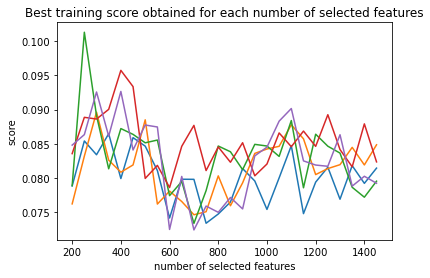

In [81]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [82]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.08456322297566812 0.8673304628632938


In [83]:
get_best_genes_names(subset, '../data/processed_data/AE3_LSK_interest.csv', '../data/optimized_subsets/AE3_LSKgenes_bestMIM.csv')

# Anova F test

test 0.10109184437616996 0.01231535823512169


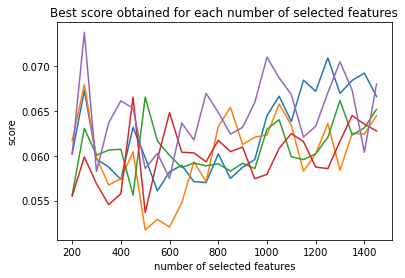

In [84]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [85]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.05660377358490566 0.9093110871905274


In [86]:
get_best_genes_names(subset, '../data/processed_data/AE3_LK_interest.csv', '../data/optimized_subsets/AE3_LKgenes_bestANOVA.csv')

# Predict on data sets separately

In [140]:
#Load AE3 data and optimized subset
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE3.csv')))
print(np.shape(AE3), np.shape(y_AE3))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE3_LSKgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE3),compute_precision,True)
x_subset = np.array(AE3.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE3)

print(model.score_,model.recovery)

(32285, 333) (333,)
0.4342105263157895 0.8558558558558559


In [141]:
#Load Weinreb LK data and optimized subset
LSK = pd.read_csv ('../data/merged_data/LSK.csv')
LSK = LSK.set_index('Unnamed: 0')
y_LSK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LSK), np.shape(y_LSK))

subset = np.squeeze(np.array(pd.read_csv('../data/optimized_subsets/AE3_LSKgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_LSK),compute_precision,True)
x_subset = np.array(LSK.loc[subset]).T
pred = model.fit_predict(x_subset,y_LSK)

print(model.score_,model.recovery)

(25289, 18980) (18980,)
0 0.0


# AE4-LSK: AE4, LSK fused

In [53]:
#Load AE3 data
AE3 = pd.read_csv ('../data/merged_data/AE4.csv')
AE3 = AE3.set_index('Unnamed: 0')
y_AE3 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE3), np.shape(y_AE3))

#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LSK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Drop genes not present in AE3
LK = LK.loc[AE3.index.intersection(LK.index)]
AE3 = AE3.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
AE3 = AE3.drop(index= AE3.index.intersection(non_unique_genes))
LK = LK.loc[AE3.index]

AE_LK = pd.concat([AE3, LK], axis=1)
print(AE_LK.shape)

#Fuse families infos
y_LK += max(y_AE3) #Add the max indice of families in first dataset so that there is no overlap between families indices.
y_AE_LK = np.hstack((y_AE3, y_LK))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(AE_LK,0.05)
AE_LK = AE_LK[gene_expressed]
print(AE_LK.shape)

#Store the name of genes of interest
genes_interest = AE_LK.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/AE4_LSK_interest.csv', index=False)

#Create preprocess data 
AE_LK.to_csv('../data/processed_data/AE4_LSK.csv', index=False)
pd.DataFrame(y_AE_LK).to_csv('../data/processed_data/y_AE4_LSK.csv', index=False)

(32285, 1473) (1473,)
(25289, 3383) (3383,)
(24176, 4856)
(8849, 4856)


# Baseline with genes expressed at least in 5% of cells

In [87]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/AE4_LSK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_AE4_LSK.csv')))
print(np.shape(AE_LK), np.shape(y))

(4856, 8849) (4856,)


In [88]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

0.07405247813411078 0.9079489291598023


# Mutual information maximizer (MIM)

test 0.11991219291556536 0.01295679128722035


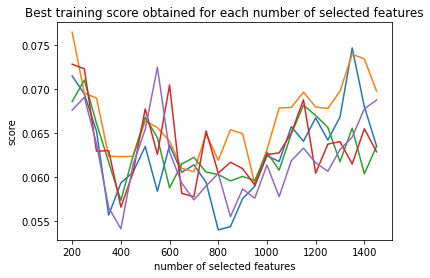

In [89]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [90]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.06442831215970962 0.8772652388797364


In [91]:
get_best_genes_names(subset, '../data/processed_data/AE4_LSK_interest.csv', '../data/optimized_subsets/AE4_LSKgenes_bestMIM.csv')

# Anova F test

test 0.13517563363716095 0.017521981296393846


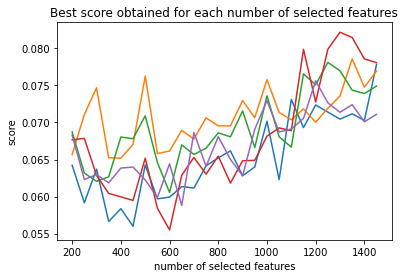

In [92]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [93]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.07314112291350532 0.8869439868204283


In [94]:
get_best_genes_names(subset, '../data/processed_data/AE4_LSK_interest.csv', '../data/optimized_subsets/AE4_LSKgenes_bestANOVA.csv')

# Predict on data sets separately

In [142]:
#Load AE3 data and optimized subset
AE4 = pd.read_csv ('../data/merged_data/AE4.csv')
AE4 = AE4.set_index('Unnamed: 0')
y_AE4 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_AE4.csv')))
print(np.shape(AE4), np.shape(y_AE4))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/AE4_LSKgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_AE4),compute_precision,True)
x_subset = np.array(AE4.loc[subset]).T
pred = model.fit_predict(x_subset,y_AE4)

print(model.score_,model.recovery)

(32285, 1473) (1473,)
0.12093023255813953 0.9287169042769857


In [143]:
#Load Weinreb LK data and optimized subset
LSK = pd.read_csv ('../data/merged_data/LSK.csv')
LSK = LSK.set_index('Unnamed: 0')
y_LSK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LSK), np.shape(y_LSK))

subset = np.squeeze(np.array(pd.read_csv('../data/optimized_subsets/AE4_LSKgenes_bestMIM.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_LSK),compute_precision,True)
x_subset = np.array(LSK.loc[subset]).T
pred = model.fit_predict(x_subset,y_LSK)

print(model.score_,model.recovery)

(25289, 18980) (18980,)
0 0.0


# MEF-LSK: MEF, LK fused

In [54]:
#Load Weinreb LK data
LK = pd.read_csv ('../data/merged_data/LSK.csv')
LK = LK.set_index('Unnamed: 0')
y_LK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LK), np.shape(y_LK))

#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

MEF = pd.concat([D0 ,D6, D15], axis=1)

#Drop genes not present in AE3
LK = LK.loc[MEF.index.intersection(LK.index)]
MEF = MEF.loc[LK.index]

#Get name of genes that are repeated in Weinreb data
genes, counts_gene = np.unique(LK.index, return_counts=True)
ind = np.where(counts_gene>1) #get indices of genes appearing more than once
non_unique_genes = genes[ind]

non_unique_genes= list(np.unique(non_unique_genes))

#Remove this genes from all data set
MEF = MEF.drop(index= MEF.index.intersection(non_unique_genes))
LK = LK.loc[MEF.index]

LK_MEF = pd.concat([LK, MEF], axis=1)
print(LK_MEF.shape)

y_D0 += max(y_LK)
y_LK_MEF = np.hstack((y_LK, y_D0))

y_D6 += max(y_LK_MEF)
y_LK_MEF = np.hstack((y_LK_MEF, y_D6))

y_D15 += max(y_LK_MEF)
y_LK_MEF = np.hstack((y_LK_MEF, y_D15))

#Remove all genes that are not expressed in at least percentage (default 50%) of the all cells
gene_expressed = filter_norm_data(LK_MEF,0.05)
LK_MEF = LK_MEF[gene_expressed]
print(LK_MEF.shape)

#Store the name of genes of interest
genes_interest = LK_MEF.index.values #get name of genes
pd.DataFrame(genes_interest).to_csv('../data/processed_data/MEF_LSK_interest.csv', index=False)

#Create preprocess data 
LK_MEF.to_csv('../data/processed_data/MEF_LSK.csv', index=False)
pd.DataFrame(y_LK_MEF).to_csv('../data/processed_data/y_MEF_LSK.csv', index=False)

(25289, 3383) (3383,)
(32285, 461) (461,)
(32285, 154) (154,)
(32285, 178) (178,)
(24176, 4176)
(8811, 4176)


# Baseline with genes expressed at least in 5% of cells

In [95]:
#Load preprocess data
AE_LK = np.array(pd.read_csv ('../data/processed_data/MEF_LSK.csv').T)
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_MEF_LSK.csv')))
print(np.shape(AE_LK), np.shape(y))

(4176, 8811) (4176,)


In [96]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE_LK,y)

print(model.score_, model.recovery)

0.12963604852686308 0.9046934865900383


# Mutual information maximizer (MIM)

test 0.211522889368943 0.009710713338228856


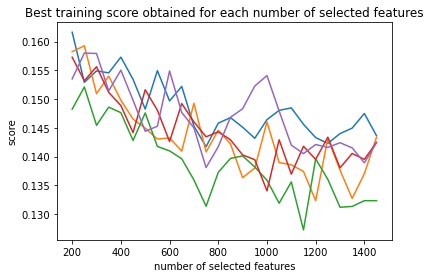

In [97]:
#Define parameters for MIM method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [98]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.1498005077983315 0.8728448275862069


In [99]:
get_best_genes_names(subset, '../data/processed_data/MEF_LSK_interest.csv', '../data/optimized_subsets/MEF_LSKgenes_bestMIM.csv')

# Anova F test

test 0.21102862212123735 0.010119367734842304


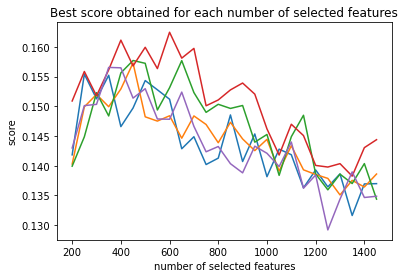

In [100]:
#Define parameters for ANOVA method
N = np.arange(200,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE_LK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [101]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE_LK[:, subset]
pred = model.fit_predict(x_subset,y)

print(model.score_, model.recovery)

0.14285714285714285 0.8967911877394636


In [102]:
get_best_genes_names(subset, '../data/processed_data/MEF_LSK_interest.csv', '../data/optimized_subsets/MEF_LSKgenes_bestANOVA.csv')

# Predict on data sets separately

In [144]:
#Load BIDDY D0 data
D0 = pd.read_csv ('../data/merged_data/D0.csv')
D0 = D0.set_index('Unnamed: 0')
y_D0 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D0.csv')))
print(np.shape(D0), np.shape(y_D0))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/MEF_LSKgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D0),compute_precision,True)
x_subset = np.array(D0.loc[subset]).T
pred = model.fit_predict(x_subset,y_D0)

print(model.score_,model.recovery)

(32285, 461) (461,)
0.90625 0.8329718004338394


In [145]:
#Load BIDDY D6 data
D6 = pd.read_csv ('../data/merged_data/D6.csv')
D6 = D6.set_index('Unnamed: 0')
y_D6 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D6.csv')))
print(np.shape(D6), np.shape(y_D6))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/MEF_LSKgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D6),compute_precision,True)
x_subset = np.array(D6.loc[subset]).T
pred = model.fit_predict(x_subset,y_D6)

print(model.score_,model.recovery)

(32285, 154) (154,)
0.8166666666666667 0.7792207792207793


In [146]:
#Load BIDDY D15 data
D15 = pd.read_csv ('../data/merged_data/D15.csv')
D15 = D15.set_index('Unnamed: 0')
y_D15 = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_D15.csv')))
print(np.shape(D15), np.shape(y_D15))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/MEF_LSKgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_D15),compute_precision,True)
x_subset = np.array(D15.loc[subset]).T
pred = model.fit_predict(x_subset,y_D15)

print(model.score_,model.recovery)

(32285, 178) (178,)
1.0 0.9775280898876404


In [147]:
#Load Weinreb LK data and optimized subset
LSK = pd.read_csv ('../data/merged_data/LSK.csv')
LSK = LSK.set_index('Unnamed: 0')
y_LSK  = np.squeeze(np.array(pd.read_csv('../data/merged_data/y_LSK.csv')))
print(np.shape(LSK), np.shape(y_LSK))

subset = np.squeeze(np.array(pd.read_csv ('../data/optimized_subsets/MEF_LSKgenes_bestANOVA.csv')))

#Predict and evaluate on data
model = FamiliesClusters(np.unique(y_LSK),compute_precision,True)
x_subset = np.array(LSK.loc[subset]).T
pred = model.fit_predict(x_subset,y_LSK)

print(model.score_,model.recovery)

(25289, 18980) (18980,)
0 0.0
